In [1]:
# Executed in https://colab.research.google.com/
!pip install keras

In [2]:
import numpy as np
import pandas as pd
import datetime
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import collections
import itertools
from pandas import Series

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Convolution1D, Dropout
from keras.optimizers import SGD
from keras.utils import np_utils

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

import sklearn.metrics as mtrcs

Using TensorFlow backend.


In [0]:
def read_zip_as_dataframe(ccyPair):
    df = pd.DataFrame()
    pth = './dl4us/data'
    for filename in os.listdir(pth):
        #if filename in ['201712_EURJPY_Week1.zip', '201712_USDJPY_Week1.zip', '201712_EURUSD_Week1.zip']:
        if filename.find(ccyPair) > 0:
            df = pd.concat([df, pd.read_csv(pth + '/' + filename, compression='zip', header=0, sep=',', quotechar='"')], axis = 0)
    # remove unnesessary columns
    df = df[['RateDateTime','CurrencyPair', 'RateBid','RateAsk']]
    df.columns = ['timestamp', 'ccyPair', 'bidPrice', 'askPrice']
    df.loc[:,'midPrice'] = Series(0.5 * (df['bidPrice'].values + df['askPrice'].values), index=df.index)

    return df

def format_data(df):
    df['timestamp'] = df['timestamp'].apply(lambda x : datetime.datetime.strptime(x[:-3], '%Y-%m-%d %H:%M:%S.%f') if len(x) > 19 else datetime.datetime.strptime(x+'.000', '%Y-%m-%d %H:%M:%S.%f') )
    return df
  
def make_data(df, agg_seconds = 60, prediction_window = 5):
  
  agg_seconds = str(agg_seconds) + 'S'
  log_return = np.log(df['midPrice'].values[1:]) - np.log(df['midPrice'][:-1].values)
  log_return = np.append(log_return, 0.0)

  df.loc[:, 'logReturn'] = log_return
  df.loc[:, 'tickUND'] = df['logReturn'].apply( lambda x : 1 if x > 0.0 else ( -1 if x < 0 else 0)).values

  df = df.set_index('timestamp')

  aggDict = {'midPrice' : { 'open' : 'first', 'high' : 'max' , 'low' : min, 'close' : 'last'}, \
            'logReturn' : { 'logReturn' : np.sum, 'volatility' : np.std, 'totalDistance' : lambda x : np.sum(np.abs(x)) }, \
            'tickUND' : {'cnt' : len, 'upRatio' : lambda x : np.sum(x>0) / len(x), 'downRatio' : lambda x : np.sum(x<0) / len(x)} \
           }

  df = df.resample(agg_seconds).agg(aggDict)
  df.columns = df.columns.droplevel(0)

  df.loc[:,'timestamp_delta'] = np.append(np.divide(df.index.values[1:] - df.index.values[:-1], 60000000000).astype(int),0)

  #NaN handling
  # by definiton, close should be forward filling
  df.loc[:,'close'] = df['close'].ffill()

  # open, high, low should be previous close if null
  for c in ['open', 'high', 'low']:
    df.loc[:,c] = [x if np.isnan(y) else y for x, y in zip (df['close'].values, df[c].values)]

  # volatility should be zero fillig
  df.loc[:,'volatility'] = df['volatility'].fillna(0.0)

  # upRatio and donwRatio should be zero filling because by defintion upRatio + downRatio + neutralRatio = 1
  for c in ['upRatio', 'downRatio']:
    df.loc[:,c] = df[c].fillna(0.0)


  # after the aggregation, the data with timesamp t1 contains the information that can be obtained btween t1 + t2 (futher information)
  # To avoid cheating, we define the data at timestamp t(k) is the information between t(k-1) and t(k)
  # To do that simply offet the data, dropping the first one

  newdf = pd.DataFrame()

  for c in df.columns:
    newdf.loc[:,c] = df[c][:-1].values

  newdf= newdf.set_index(df.index[1:])

  newdf.loc[:-prediction_window,'priceChange'] = newdf['close'].values[prediction_window:] - newdf['close'].values[0:-prediction_window]

  return newdf


def make_sliding_data( df, window_size, get_fulldata_only = True ):
  colnames = df.columns.values
  newdf = pd.DataFrame()

  colnames = colnames[colnames != 'priceChange']

  for c in colnames:
    x = df[c].values
    x_sliding = [x[np.max([(i-window_size)+1, 0]):i+1] for i in np.arange(len(x))]
    newdf.loc[:, c] = x_sliding

  newdf.loc[:,'priceChange'] = df['priceChange'].values
  
  if get_fulldata_only:
    newdf = newdf[newdf[colnames[0]].apply( lambda x : len(x) == window_size)]
    newdf = newdf.set_index(df.index[window_size-1:])
  else:
    newdf = newdf.set_index(df.index)

  newdf = newdf[~np.isnan(newdf['priceChange'].values)]
                        
  return newdf

def shuffle_with_same_seed (x, y):
  rndm_state = np.random.get_state()
  np.random.set_state(rndm_state)
  np.random.shuffle(x)
  np.random.set_state(rndm_state)
  np.random.shuffle(y)  
  return x, y

def balance_data(X, y):
  
  cnts = [0,0,0]
  for i, unique_value in zip(np.arange(len(np.unique(y))), np.unique(y)):
    cnts[i] = sum(y == unique_value)
    
  datanum_to_reduce = np.min(cnts) - cnts

  for i, unique_value in zip(np.arange(len(np.unique(y))), np.unique(y)):
    y_tmp = np.array(y)[np.array(y == unique_value)]
    X_tmp = X[np.array(y == unique_value)]
    X_tmp, y_tmp = shuffle_with_same_seed(X_tmp, y_tmp)
    X_tmp = np.array(X_tmp)
    y_tmp = np.array(y_tmp)
    if datanum_to_reduce[i] < 0:
      X_tmp = X_tmp[:datanum_to_reduce[i]]
      y_tmp = y_tmp[:datanum_to_reduce[i]]

    if i == 0:
      X_new = X_tmp
      y_new = y_tmp
    else:
      X_new = np.append(X_new, X_tmp, axis = 0)
      y_new = np.append(y_new, y_tmp, axis = 0)
      
  return X_new, y_new

def make_dataset(df, window_size, feature_columns, pricemove_threshold, balance_train_data, shuffledata, train_weight ):

  X = np.zeros((len(df), window_size, len(feature_columns)))

  for i, c in zip( np.arange(len(feature_columns)), feature_columns):
    data = df[c].values
    X[:,:,i] = np.vstack(data)

  f = lambda x : 1 if x >= pricemove_threshold else ( 2 if x <= -1 * pricemove_threshold else 0)
  y = [f(x) for x in df['priceChange'].values]

  if shuffledata:
    X, y = shuffle_with_same_seed(X, y)

  to_index = int(train_weight * len(X))

  X_train = X[:to_index]
  y_train = y[:to_index]
  X_test = X[to_index:]
  y_test = y[to_index:]
  
  if balance_train_data:
    X_train, y_train = balance_data(X_train, y_train)
  
  num_class = 3

  y_train = np_utils.to_categorical(y_train, num_class)
  y_test = np_utils.to_categorical(y_test, num_class)
  
  
  return X_train, y_train, X_test, y_test 

def normalize_data(X_train, X_test):
  for i in np.arange(X_train.shape[2]):
    train_mean = np.mean(X_train[:,:,i])
    train_std = np.std(X_train[:,:,i])

    X_train[:,:,i] = (X_train[:,:,i] - train_mean) / train_std
    X_test[:,:,i] = (X_test[:,:,i] - train_mean) / train_std
  
 
  return X_train, X_test


def get_distribution(y):
  
  neutral = np.sum(y[:,0])
  up = np.sum(y[:,1])
  down = np.sum(y[:,2])
  total = np.sum(y)
  
  neutral = neutral / total
  up = up / total
  down = down / total
  
  return up, neutral, down



def get_confusion_matrix ( y_true, y_pred):

  y_true = np.argmax(y_true, axis = 1)

  y_true_label = []
  y_pred_label = []


  f = lambda x : 'U' if x == 1 else ( 'D' if x == 2 else 'N')

  y_true_label = [f(x) for x in y_true]
  y_pred_label = [f(x) for x in y_pred]


  conf_matrix = np.zeros((3,3))
  i = 0
  for result, pred in itertools.product(['U', 'N', 'D'], ['U', 'N', 'D'] ):
    conf_matrix[i%3, (3*i)//9] = np.sum(( np.array(y_pred_label) == pred ) * ( np.array(y_true_label) == result ))
    i =i + 1 

  df = pd.DataFrame(conf_matrix / np.sum(conf_matrix), columns = ['U', 'N', 'D'])
  df = pd.concat((df, pd.DataFrame({ 'pred' : ['U', 'N', 'D']})), axis = 1)

  df = df.loc[:,['pred','U','N', 'D']]
  
  return df


def get_evaluation_matrix (conf_matrix):

  somethingsmall = 0.000000000000001

  conf_mat = conf_matrix[['U', 'N', 'D']].values

  prec_total = np.sum([ conf_mat[i,i] for i in np.arange(3)])

  prec_u = conf_mat[0,0] / np.sum(conf_mat[0,:] + somethingsmall)

  prec_n = conf_mat[1,1] / np.sum(conf_mat[1,:] + somethingsmall)

  prec_d = conf_mat[2,2] / np.sum(conf_mat[2,:] + somethingsmall)

  prec_ud = ( conf_mat[0,0] + conf_mat[2,2]) / ( np.sum(conf_mat[0,:]) + np.sum(conf_mat[2,:]) + somethingsmall)

  coverage_u = np.sum(conf_mat[0,:]) / np.sum(conf_mat)

  coverage_d = np.sum(conf_mat[2,:]) / np.sum(conf_mat)

  coverage_ud = coverage_u + coverage_d

  profit_ratio_u = conf_mat[0,0] / ( conf_mat[0,0] + conf_mat[0,2] + somethingsmall)

  profit_ratio_d = conf_mat[2,2] / ( conf_mat[2,0] + conf_mat[2,2] + somethingsmall)

  profit_ratio_ud = ( conf_mat[0,0] + conf_mat[2,2] ) / ( conf_mat[0,0] + conf_mat[0,2] + conf_mat[2,0] + conf_mat[2,2] + somethingsmall )

  nobig_loss_ratio_u  = ( conf_mat[0,0] + conf_mat[0,1] ) / ( np.sum(conf_mat[0,:]) + somethingsmall )

  nobig_loss_ratio_d  = ( conf_mat[2,1] + conf_mat[2,2] ) / ( np.sum(conf_mat[2,:]) + somethingsmall )

  nobig_loss_ratio_ud = ( conf_mat[0,0] + conf_mat[0,1] + conf_mat[2,1] + conf_mat[2,2] ) / ( np.sum(conf_mat[0,:]) + np.sum(conf_mat[2,:]) +  somethingsmall )

  df = pd.DataFrame(  \
                      { 'coverage' : { 'u' : coverage_u, 'd' : coverage_d, 'ud' : coverage_ud}, 
                        'precision' : { 'u' : prec_u, 'd' : prec_d, 'ud' : prec_ud},
                        'profit_ratio' : { 'u' : profit_ratio_u, 'd' : profit_ratio_d, 'ud' : profit_ratio_ud},
                        'nobig_loss_ratio' : { 'u' : nobig_loss_ratio_u, 'd' : nobig_loss_ratio_d, 'ud' : nobig_loss_ratio_ud},
                      } )

  df = df.loc[['u','d','ud'],['coverage', 'precision', 'profit_ratio', 'nobig_loss_ratio']]

  return df

def check_normalized_data( train, test, feature_columns ):
  
  tmpdf = pd.DataFrame({ 'data' : [ 'train_mean', 'test_mean', 'train_std', 'test_std']})
  for i in np.arange(len(feature_columns)):
    tmpdf = pd.concat([tmpdf, pd.DataFrame({ feature_columns[i] : [ np.mean(train[:,:,i]), np.mean(test[:,:,i]),np.std(train[:,:,i]), np.std(test[:,:,i]) ] })], axis = 1 )

  return tmpdf


In [4]:
# build data set
# load csv file
df = read_zip_as_dataframe('USDJPY')
# data formatting
df = format_data(df)

# we do 5 minutes prediction
df = make_data(df, agg_seconds = 60, prediction_window = 5)

# for test
#df = df[:10000]
keep = df.copy()

# make sliding widow data
window_size = 30
df = make_sliding_data(df, window_size = window_size)

# feature_columns = ['open', 'high', 'low', 'close']
feature_columns = ['open', 'high', 'low', 'close', 'logReturn', 'volatility', 'totalDistance', 'cnt', 'upRatio', 'downRatio']
X_train, y_train, X_test, y_test = make_dataset(df, window_size = window_size, \
                                                feature_columns = feature_columns, \
                                                pricemove_threshold = 3 * 0.01, \
                                                balance_train_data = True, shuffledata = True, train_weight= 0.7 )

# normalizd data
X_train, X_test = normalize_data(X_train, X_test)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: RuntimeWarning: invalid value encountered in long_scalars


In [5]:
# Model definition
num_class = 3
num_feature = len(feature_columns)
if 'model' in locals():
  del model
model = Sequential()
model.add(Conv1D(nb_filter=32, filter_length=1, input_shape=(window_size, num_feature)))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dense(num_class))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])



/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(30, 10), filters=32, kernel_size=1)`
  


Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead


In [6]:
# Learning
num_epoch = 20
history = model.fit(X_train, y_train, nb_epoch=num_epoch, validation_data=(X_train[:1000], y_train[:1000]), batch_size=1024)

y_train_prediction = model.predict_classes(X_train)
y_test_prediction = model.predict_classes(X_test)


/usr/local/lib/python3.6/dist-packages/keras/models.py:942: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 22569 samples, validate on 1000 samples
Epoch 1/20
22569/22569 [==============================] - 1s 66us/step - loss: 0.9476 - acc: 0.4836 - val_loss: 0.7133 - val_acc: 0.6730
Epoch 2/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.9211 - acc: 0.4945 - val_loss: 0.7191 - val_acc: 0.6660
Epoch 3/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.9149 - acc: 0.5029 - val_loss: 0.7973 - val_acc: 0.6200
Epoch 4/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.9115 - acc: 0.5019 - val_loss: 0.7293 - val_acc: 0.6670
Epoch 5/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.9094 - acc: 0.5032 - val_loss: 0.7426 - val_acc: 0.6460
Epoch 6/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.9091 - acc: 0.5075 - val_loss: 0.8598 - val_acc: 0.6060
Epoch 7/20
22569/22569 [==============================] - 1s 60us/step - loss: 0.9077 - acc: 0.5096 - val_loss: 0.8014 - val_acc:

22569/22569 [==============================] - 1s 59us/step - loss: 0.9039 - acc: 0.5160 - val_loss: 0.7649 - val_acc: 0.6390
Epoch 9/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.9025 - acc: 0.5158 - val_loss: 0.8358 - val_acc: 0.5900
Epoch 10/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.8998 - acc: 0.5169 - val_loss: 0.7381 - val_acc: 0.6450
Epoch 11/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.9046 - acc: 0.5175 - val_loss: 0.7568 - val_acc: 0.6290
Epoch 12/20
22569/22569 [==============================] - 1s 58us/step - loss: 0.8974 - acc: 0.5181 - val_loss: 0.7552 - val_acc: 0.6480
Epoch 13/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.8953 - acc: 0.5231 - val_loss: 0.7937 - val_acc: 0.6190
Epoch 14/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.8942 - acc: 0.5232 - val_loss: 0.7612 - val_acc: 0.6460
Epoch 15/20
15360/22569 [===================>..

22569/22569 [==============================] - 1s 61us/step - loss: 0.8911 - acc: 0.5267 - val_loss: 0.7654 - val_acc: 0.6360
Epoch 16/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.8885 - acc: 0.5272 - val_loss: 0.7267 - val_acc: 0.6500
Epoch 17/20
22569/22569 [==============================] - 1s 59us/step - loss: 0.8871 - acc: 0.5320 - val_loss: 0.7521 - val_acc: 0.6240
Epoch 18/20
22569/22569 [==============================] - 1s 58us/step - loss: 0.8875 - acc: 0.5348 - val_loss: 0.8029 - val_acc: 0.5930
Epoch 19/20
22569/22569 [==============================] - 1s 60us/step - loss: 0.8811 - acc: 0.5371 - val_loss: 0.7238 - val_acc: 0.6530
Epoch 20/20
22569/22569 [==============================] - 1s 58us/step - loss: 0.8798 - acc: 0.5396 - val_loss: 0.7662 - val_acc: 0.6130


Text(0,0.5,'accuracy')

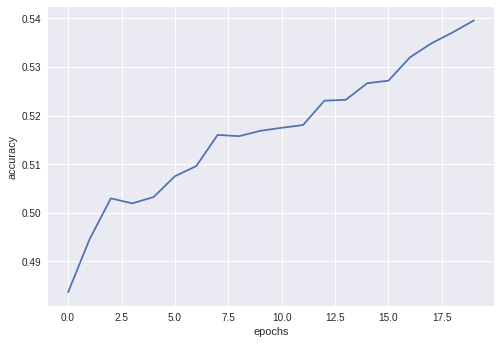

In [7]:
fig, ax = plt.subplots()
ax.plot(np.arange(num_epoch), history.history['acc'])
ax.set_xlabel("epochs")
ax.set_ylabel("accuracy")
 

In [8]:
# confusion matrix of the last epoc of training
conf_train = get_confusion_matrix(y_train, y_train_prediction)
conf_train

,pred,U,N,D
0,U,0.171607,0.066684,0.110328
1,N,0.028269,0.201117,0.029111
2,D,0.133457,0.065532,0.193894


In [9]:
# signal evaluation matrix of the last epoc of traning
get_evaluation_matrix(conf_train)

,coverage,precision,profit_ratio,nobig_loss_ratio
u,0.348620,0.492247,0.608675,0.683528
d,0.392884,0.493515,0.592312,0.660314
ud,0.741504,0.492919,0.599884,0.671228


In [10]:
# confusion matrix of test 
conf_test = get_confusion_matrix(y_test, y_test_prediction)
conf_test

,pred,U,N,D
0,U,0.035017,0.180524,0.034211
1,N,0.009236,0.476534,0.008143
2,D,0.042042,0.171367,0.042926


In [11]:
# signal evaluation matrix of test
get_evaluation_matrix(conf_test)

,coverage,precision,profit_ratio,nobig_loss_ratio
u,0.249753,0.140208,0.505825,0.863021
d,0.256335,0.167462,0.505205,0.835989
ud,0.506088,0.154012,0.505483,0.849329


In [12]:
# Check input distribution
check_normalized_data( X_train, X_test, feature_columns )


,data,open,high,low,close,logReturn,volatility,totalDistance,cnt,upRatio,downRatio
0,train_mean,1.746566e-14,-2.703418e-14,5.332822e-16,-1.072005e-14,-7.083704e-19,1.455780e-16,3.297753e-16,-1.947756e-17,1.309698e-17,2.982082e-16
1,test_mean,2.480682e-01,2.470206e-01,2.491635e-01,2.481159e-01,5.518509e-03,-5.806836e-02,-3.088849e-01,-4.111296e-01,-4.563962e-01,-4.594147e-01
2,train_std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
3,test_std,1.035634e+00,1.035772e+00,1.035466e+00,1.035615e+00,1.379785e+00,1.789777e+00,8.941699e-01,9.296934e-01,1.307654e+00,1.307017e+00


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 30, 32)            352       
_________________________________________________________________
activation_1 (Activation)    (None, 30, 32)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 960)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 960)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               246016    
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 771       
_________________________________________________________________
activation_2 (Activation)    (None, 3)                 0         
Total para